In [1]:
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model


from env_test import GridEnvironment
from DQL_agent import DQNAgent
from DQL_agent_noreplay import DQNAgent_nr

In [2]:
# Load data
N = 10 # 10 EVs

# Get demand data
# TODO get apparent power from real and reactive, use just real for now
with open('Building Load Data/real_power_data.json', 'r') as json_file:
    real_dict = json.load(json_file)
    for key in real_dict.keys(): # get data from first key only (CAPTL_WF)
        demand_data = np.array(real_dict[key])
        break

# Get solar data
with open('PV Generation Data/pv_data.json', 'r') as json_file:
    pv_dict = json.load(json_file)
    for key in pv_dict.keys(): # get data from first key only (CAPTL_WF)
        solar_data = np.array(pv_dict[key])
        break

# Get wind data
with open('Wind Data/wind_data.json', 'r') as json_file:
    wind_dict = json.load(json_file)
    for key in wind_dict.keys(): # get data from first key only (CAPTL_WF)
        wind_data = np.array(wind_dict[key])
        break

In [3]:
#Quick fix for scaling Data
demand_data=demand_data/300
wind_data=wind_data*10

In [4]:
#USING AGENT WITHOUT REPLAY ONE EPISODE
day_index=19 #random
timestep_length=.25 #in hours
batch_size = 10 #TWEAk

env = GridEnvironment(N, demand_data, solar_data, wind_data, day_index, timestep_length)
agent = DQNAgent_nr(state_size=env.state_size, action_size=env.action_size)


# Run for one episode (one day)
state = env.get_state()  # Reset environment to start state
total_reward = 0

T=96 #(15 minute steps in 24 hrs)

demand_profile = np.zeros(T)
solar_profile = np.zeros(T)
wind_profile = np.zeros(T)
PEV_profile = np.zeros(T)

for timestep in range(1, T+1):  # Assume T timesteps in a day

    current_demand, current_solar, current_wind = env.get_state()
    current_P_EV=env.P_EV

    current_state=np.concatenate([np.array([current_demand, current_solar, current_wind]), np.array(current_P_EV)])
    action = agent.act(state)  # Decide action based on current state

    # Execute action in the environment and observe the next state, reward, and done flag
    reward, done, next_demand, next_solar, next_wind, next_P_EV = env.step(action)


    # Update profiles for plotting
    demand_profile[timestep - 1] = next_demand
    solar_profile[timestep - 1] = next_solar
    wind_profile[timestep - 1] = next_wind
    PEV_profile[timestep - 1] = np.sum(next_P_EV)
    

    # Construct the new state from the separated components
    next_state = np.concatenate([np.array([next_demand, next_solar, next_wind]), np.array(next_P_EV)])
    
    # Directly learn from this transition without using replay
    agent.learn(current_state, action, reward, next_state, done)

    # Update state and total_reward
    state = next_state
    total_reward += reward

    if done:
        # Handle episode completion, if applicable
        break

print("Total reward for the episode (day):", total_reward)




1/1 [==============================] - 0s 41ms/step


2024-04-11 21:48:51.454472: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


IndexError: invalid index to scalar variable.

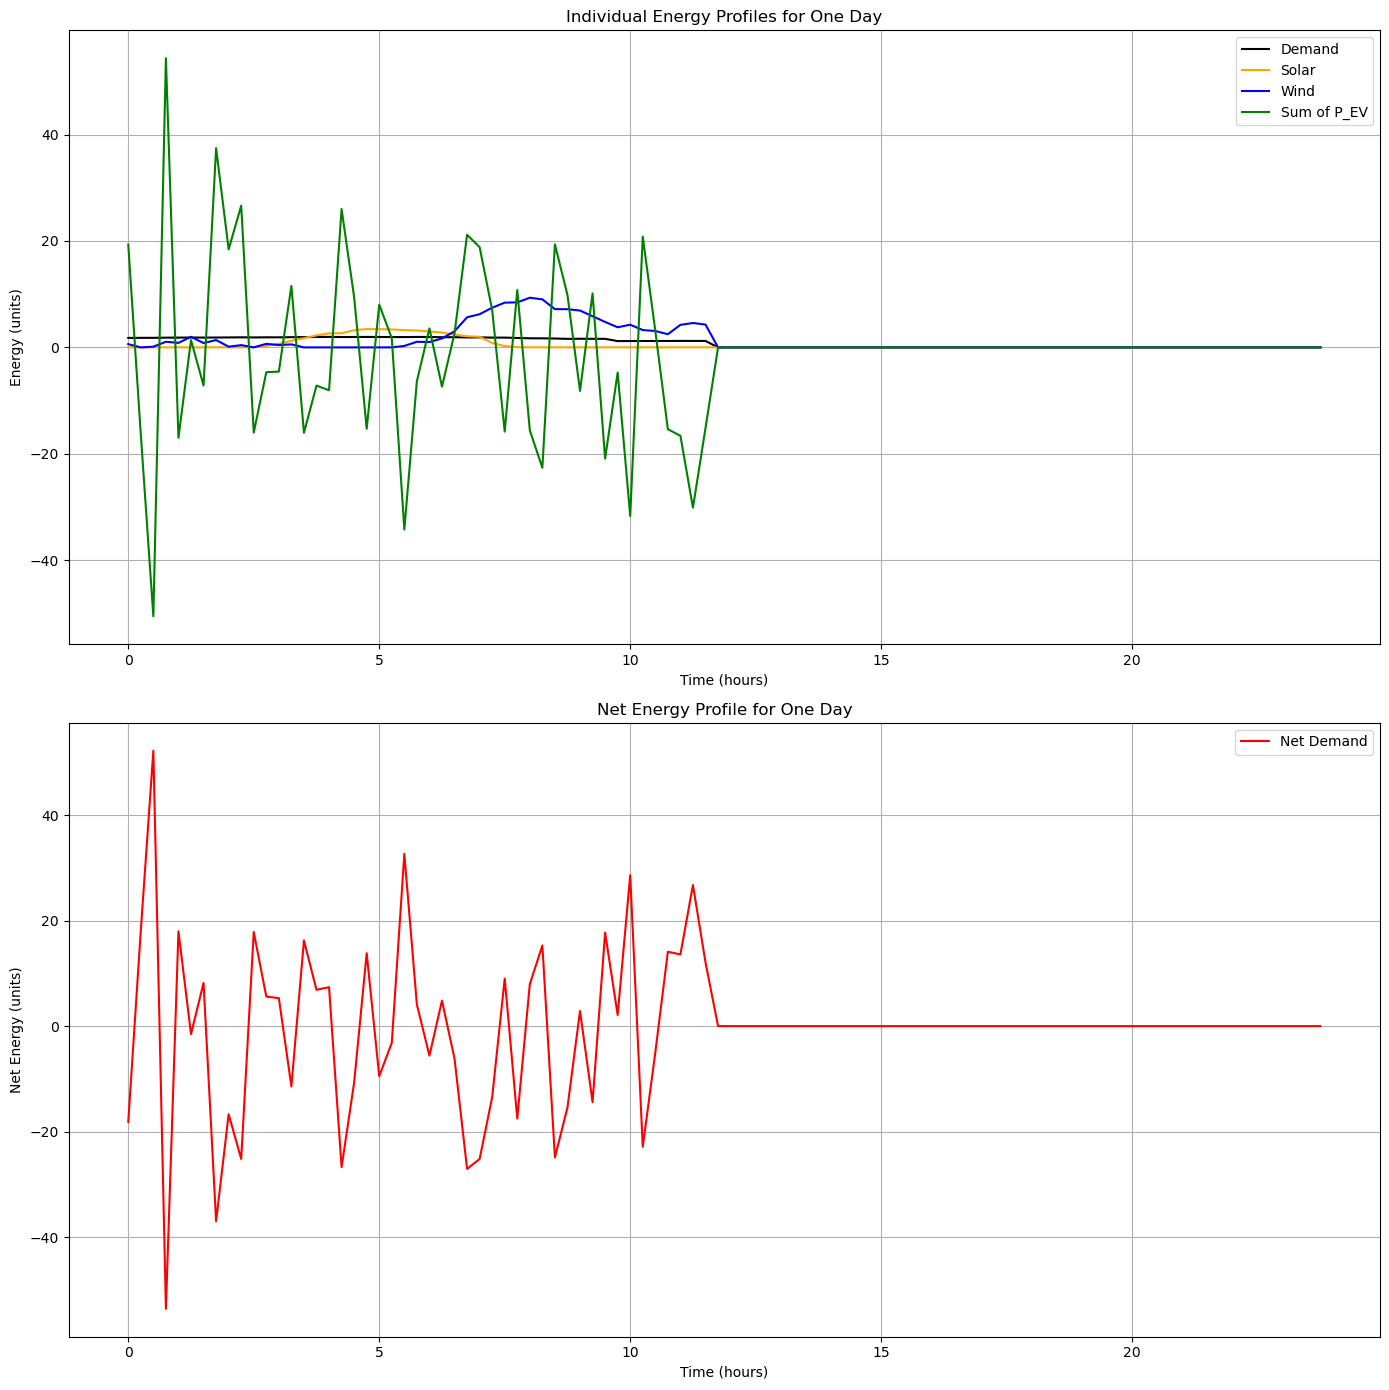

In [ ]:
#Plot Episode

time_steps = np.arange(0, T * timestep_length, timestep_length)  # Generate a time axis

plt.figure(figsize=(14, 14))  # Increase the figure size to accommodate two subplots

# First subplot for individual profiles
plt.subplot(2, 1, 1)  # (rows, columns, panel number)
plt.plot(time_steps, demand_profile, label='Demand', color='black')
plt.plot(time_steps, solar_profile, label='Solar', color='orange')
plt.plot(time_steps, wind_profile, label='Wind', color='blue')
plt.plot(time_steps, PEV_profile, label='Sum of P_EV', color='green')
plt.xlabel('Time (hours)')
plt.ylabel('Energy (units)')
plt.title('Individual Energy Profiles for One Day')
plt.legend()
plt.grid(True)

# Second subplot for net demand
plt.subplot(2, 1, 2)  # (rows, columns, panel number)
net_demand_profile = demand_profile - solar_profile - wind_profile-PEV_profile
plt.plot(time_steps, net_demand_profile, label='Net Demand', color='red')
plt.xlabel('Time (hours)')
plt.ylabel('Net Energy (units)')
plt.title('Net Energy Profile for One Day')
plt.legend()
plt.grid(True)

# Show both plots
plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure
plt.show()

In [ ]:
#Attempt to loop through multiple episodes
day_index=0 
timestep_length=.25 #in hours
batch_size = 32 #TWEAk
env = GridEnvironment(N, demand_data, solar_data, wind_data, day_index, timestep_length)

# Initialize DQN agent
agent = DQNAgent_nr(state_size=env.state_size, action_size=env.action_size)

## Initialize DQN agent
agent = DQNAgent_nr(state_size=env.state_size, action_size=env.action_size)

for day_index in range(50):  # Loop over 50 episodes
    # Initialize environment for the current day
    env = GridEnvironment(N, demand_data, solar_data, wind_data, day_index, timestep_length)
    
    # Reset environment to start state for the new episode
    state = env.reset(day_index)  # Assuming reset method is correctly set up to also return the initial state

    total_reward = 0
    T = 96  # Assume T timesteps in a day

    demand_profile = np.zeros(T)
    solar_profile = np.zeros(T)
    wind_profile = np.zeros(T)
    PEV_profile = np.zeros(T)

    for timestep in range(1, T+1):  # Loop through each timestep in the day

        current_demand, current_solar, current_wind = env.get_state()
        current_P_EV = env.P_EV

        current_state = np.concatenate([np.array([current_demand, current_solar, current_wind]), np.array(current_P_EV)])
        action = agent.act(current_state)  # Ensure to pass the current state, not the initial state

        # Execute action in the environment and observe the next state, reward, and done flag
        reward, done, next_demand, next_solar, next_wind, next_P_EV = env.step(action)

        # Update profiles for plotting
        demand_profile[timestep - 1] = next_demand
        solar_profile[timestep - 1] = next_solar
        wind_profile[timestep - 1] = next_wind
        PEV_profile[timestep - 1] = np.sum(next_P_EV)

        # Construct the new state from the separated components
        next_state = np.concatenate([np.array([next_demand, next_solar, next_wind]), np.array(next_P_EV)])
        
        # Directly learn from this transition without using replay
        agent.learn(current_state, action, reward, next_state, done)

        # Update state and total_reward
        state = next_state
        total_reward += reward

        if done:
            break

    print(f"Total reward for day {day_index}: {total_reward}")



1/1 [==============================] - 0s 10ms/step
Total reward for day 0: -980.1012013328265
1/1 [==============================] - 0s 12ms/step
Total reward for day 1: -827.4978451340328
1/1 [==============================] - 0s 11ms/step
Total reward for day 2: -949.3300998526183
1/1 [==============================] - 0s 11ms/step
Total reward for day 3: -796.8431616602423
1/1 [==============================] - 0s 11ms/step
Total reward for day 4: -892.9376380826662
1/1 [==============================] - 0s 11ms/step
Total reward for day 5: -872.1500346333631
1/1 [==============================] - 0s 11ms/step
Total reward for day 6: -806.4753814442448
1/1 [==============================] - 0s 10ms/step
Total reward for day 7: -813.7479834338351
1/1 [==============================] - 0s 11ms/step
Total reward for day 8: -1013.905451432942
1/1 [==============================] - 0s 12ms/step
Total reward for day 9: -1010.3272283106438
1/1 [==============================] - 0s 11ms/st

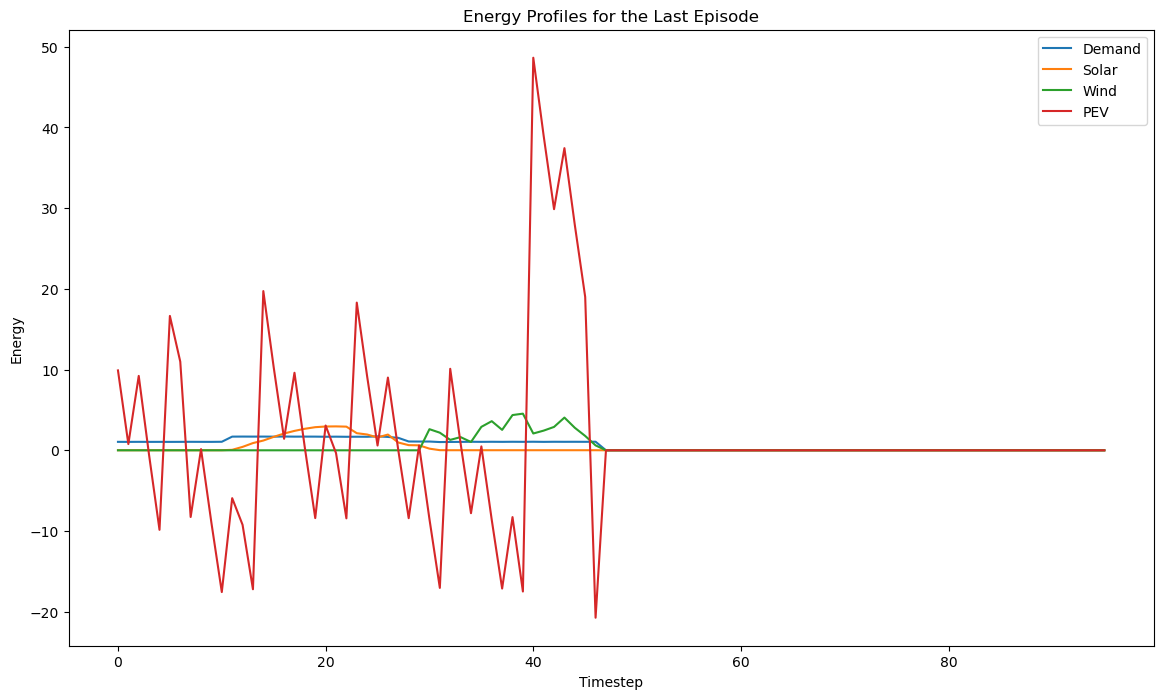

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(demand_profile, label='Demand')
plt.plot(solar_profile, label='Solar')
plt.plot(wind_profile, label='Wind')
plt.plot(PEV_profile, label='PEV')
plt.legend()
plt.title('Energy Profiles for the Last Episode')
plt.xlabel('Timestep')
plt.ylabel('Energy')
plt.show()